In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import time as t
from datetime import datetime
from datetime import date
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set_theme(style="darkgrid")
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("datatraining.txt")
train['date'] = pd.to_datetime(train['date'])
test1 = pd.read_csv("datatest.txt")
test1['date'] = pd.to_datetime(test1['date'])
test2 = pd.read_csv("datatest2.txt")
test2['date'] = pd.to_datetime(test2['date'])
test = pd.concat([test1, test2])
all_data = pd.concat([train,test])

**date time** year-month-day hour:minute:second 

**Temperature**, in Celsius 

**Relative Humidity**, % 

**Light**, in Lux 

**CO2**, in ppm 

**Humidity Ratio**, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air 

**Occupancy**, 0 or 1, 0 for not occupied, 1 for occupied status

# Correlation

The only imporant column here is the bottom Occupancy row, which shows that light has the strongest correlation with Occupany.  We see a 0.96 correlation with humidity and humidityraio, we then can remove it to reduce redundancy and improve the model

<AxesSubplot:>

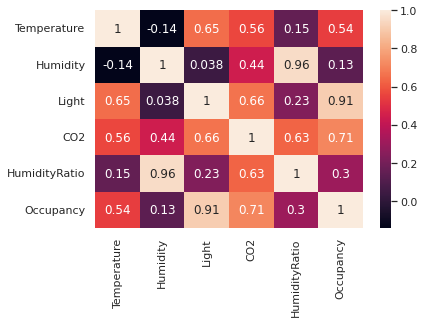

In [3]:
sns.heatmap(train.corr(), annot=True)

Date is not needed for prediction. There are ways to include a date into the model, but it would reduce the model performance and not help with overfitting. Humidity Ratio is a derived quantity from temperature and relative humidity, so it's something we could throw out.

## PCA of raw data

This is usefull to see how well a model might perform.  If there is high seperability in the PCA, then there is a good chance a model will be able to predict well.

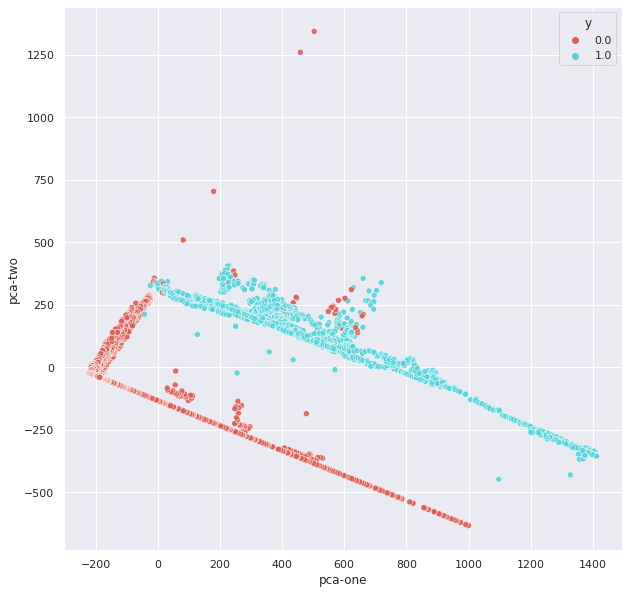

In [4]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train.drop(columns=['date', 'HumidityRatio', 'Occupancy']))
# convert it to df just to easily use seabourn plotting
y = train.Occupancy.values.reshape(-1,1)
df_pca = pd.DataFrame(data=np.append(pca_result,y,axis=1),columns=['pca-one','pca-two','y'])

plt.figure(figsize=(10,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_pca,
    legend="full",
    alpha=0.9
)
plt.show()

The above graph looks like it's highly seperable, which is a good sign for performing predictions.  Looks like there ae some outliers in the dataset, but we will leave these in, as it looks like the quantity is small enough that they wouldn't be a problem during prediction time.

## Train Class Bias

occupancy:    6414 
no occupancy: 1729


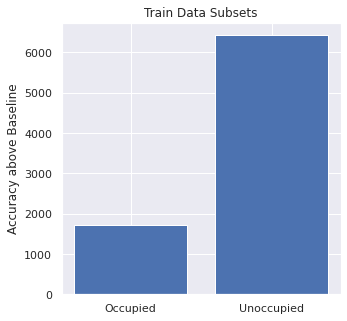

In [41]:
y = train.Occupancy.values.reshape(-1,1)
print("occupancy:    %i \nno occupancy: %i" %(np.sum(y == 0), np.sum(y == 1)))
plt.figure(figsize=(5,5))
plt.bar(['Occupied', 'Unoccupied'], [np.sum(y == 1), np.sum(y == 0)])
plt.ylabel('Accuracy above Baseline')
plt.title('Train Data Subsets')
plt.show()

This is a significant imballance of data, so this will have to be accounted for during the learning, or data will be to be removed in preprocessing.

## Viewing all datapoints 

0 = Unoccupied;
1 = Occupied

### Occupancy

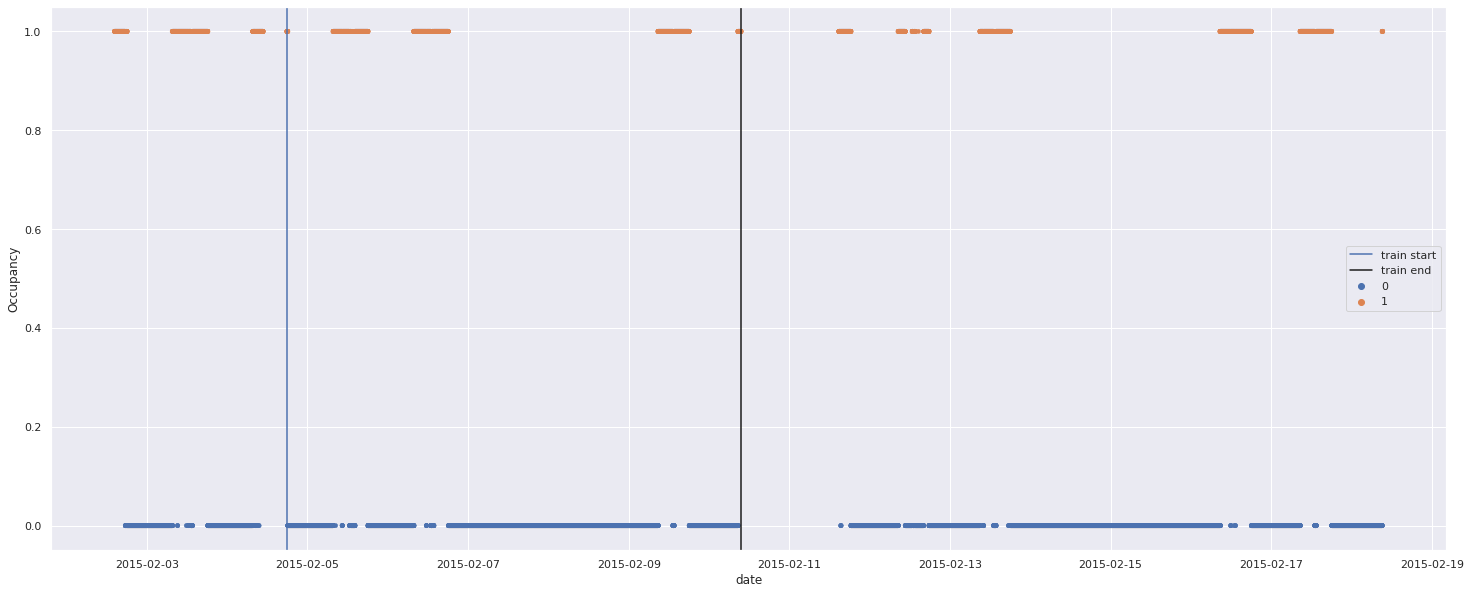

In [52]:
train_start = train.date.min()
train_end = train.date.max()

plt.figure(figsize=(25,10))
plt.axvline(x = train_start, color = 'b', label = 'train start')
plt.axvline(x = train_end, color = 'k', label = 'train end')
sns.scatterplot(all_data.date,all_data.Occupancy, hue = all_data.Occupancy, s= 20,edgecolor=None)
plt.legend()
plt.show()

### Temperature

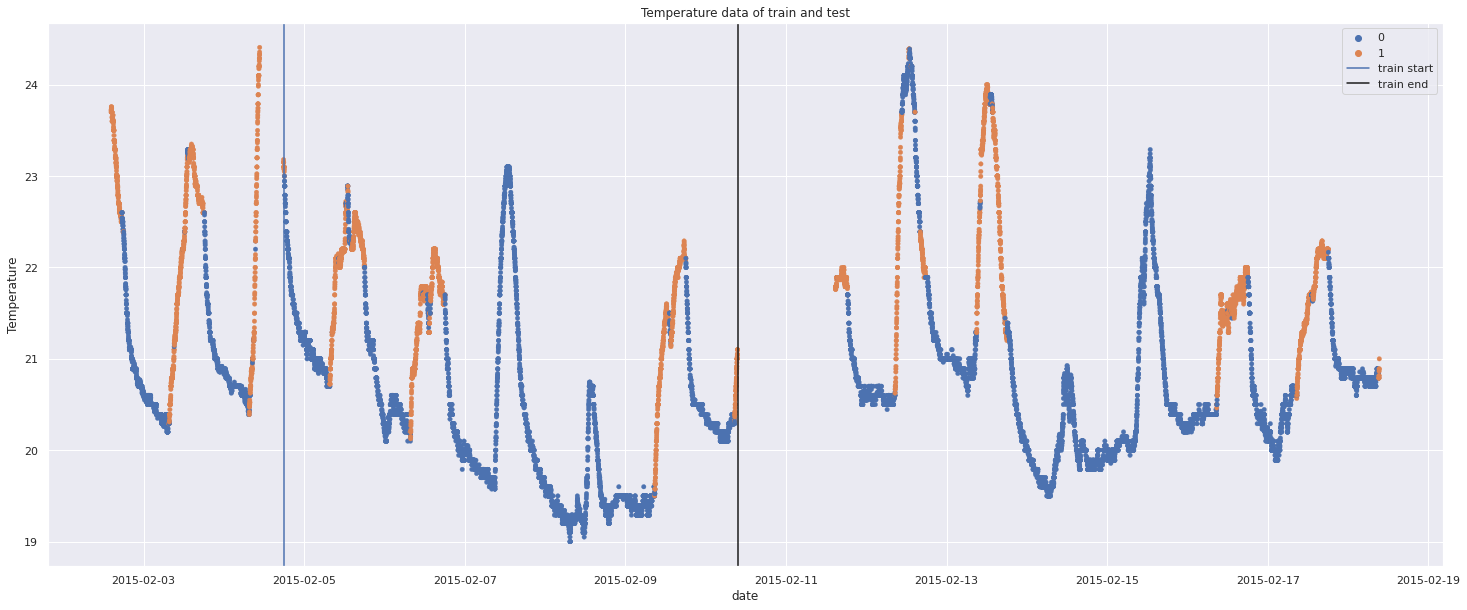

In [51]:
plt.figure(figsize=(25,10))
sns.scatterplot(all_data.date,all_data.Temperature, hue = all_data.Occupancy, s= 20,edgecolor=None)
plt.title('Temperature data of train and test')
plt.axvline(x = train_start, color = 'b', label = 'train start')
plt.axvline(x = train_end, color = 'k', label = 'train end')
plt.legend()
plt.show()

### Light Lux

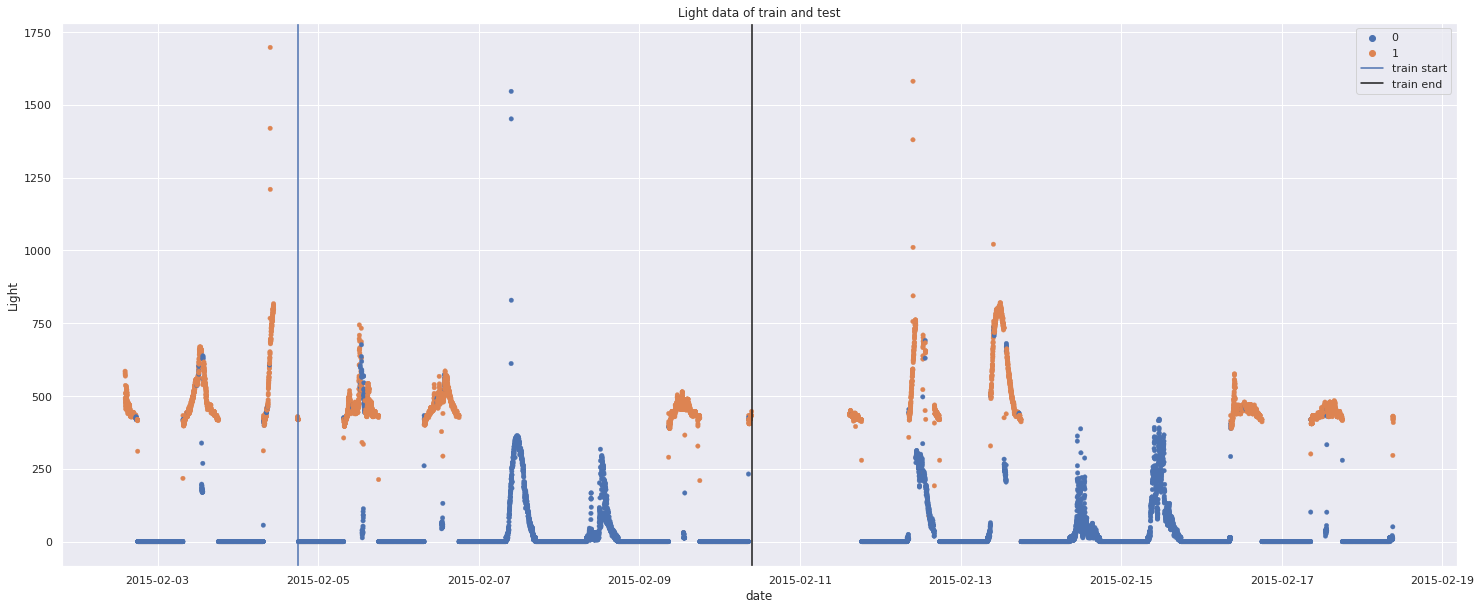

In [50]:
plt.figure(figsize=(25,10))
sns.scatterplot(all_data.date,all_data.Light, hue = all_data.Occupancy, s= 20,edgecolor=None)
plt.title('Light data of train and test')
plt.axvline(x = train_start, color = 'b', label = 'train start')
plt.axvline(x = train_end, color = 'k', label = 'train end')
plt.legend()
plt.show()

2015-02-07 was a Saturday, and 2015-02-08 was a Sunday, here we can see those days Lux have considerablly less light than the other days. 


### CO2

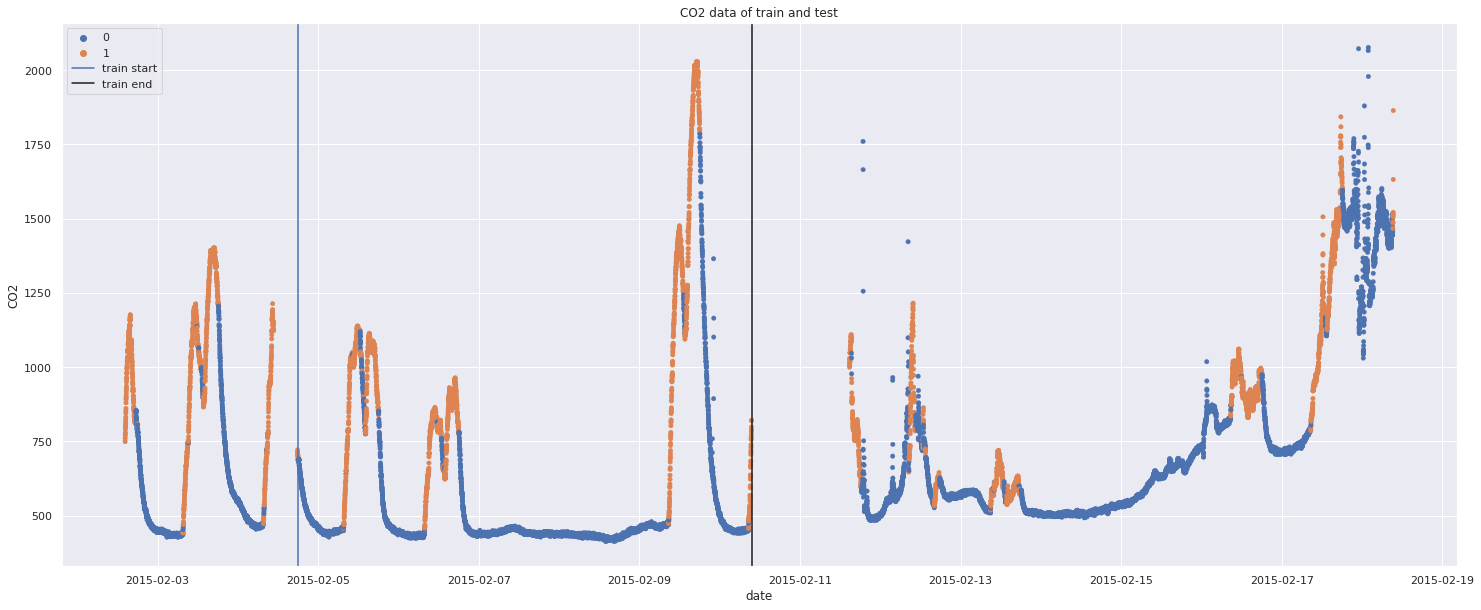

In [47]:
plt.figure(figsize=(25,10))
sns.scatterplot(all_data.date,all_data.CO2, hue = all_data.Occupancy, s= 20,edgecolor=None)
plt.title('CO2 data of train and test')
plt.axvline(x = train_start, color = 'b', label = 'train start')
plt.axvline(x = train_end, color = 'k', label = 'train end')
plt.legend()
plt.show()

### Humidity

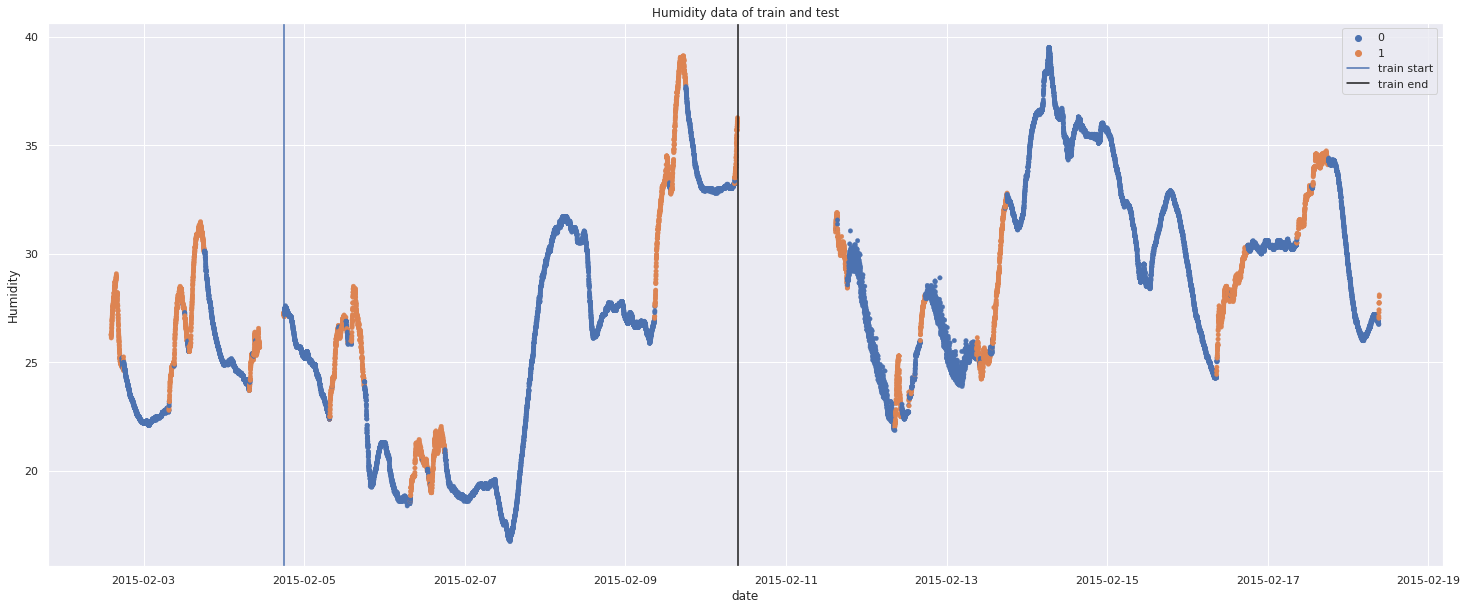

In [48]:
plt.figure(figsize=(25,10))
sns.scatterplot(all_data.date,all_data.Humidity, hue = all_data.Occupancy, s= 20,edgecolor=None)
plt.title('Humidity data of train and test')
plt.axvline(x = train_start, color = 'b', label = 'train start')
plt.axvline(x = train_end, color = 'k', label = 'train end')
plt.legend()
plt.show()

## Only considering weekdays

In [11]:
weekday_data = all_data[ all_data['date'].dt.weekday < 5]

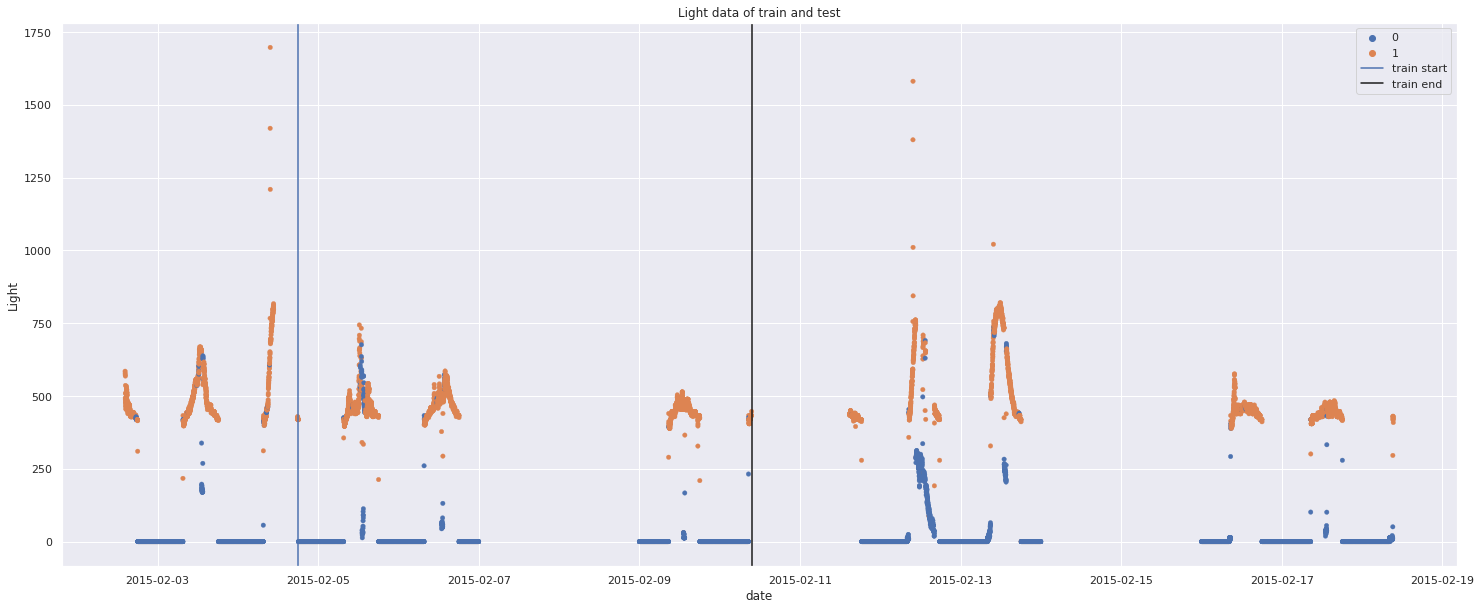

In [53]:
plt.figure(figsize=(25,10))
sns.scatterplot(weekday_data.date,weekday_data.Light, hue = weekday_data.Occupancy, s= 20,edgecolor=None)
plt.title('Light data of train and test')
plt.axvline(x = train_start, color = 'b', label = 'train start')
plt.axvline(x = train_end, color = 'k', label = 'train end')
plt.legend()
plt.show()

## Only considering Working Hours

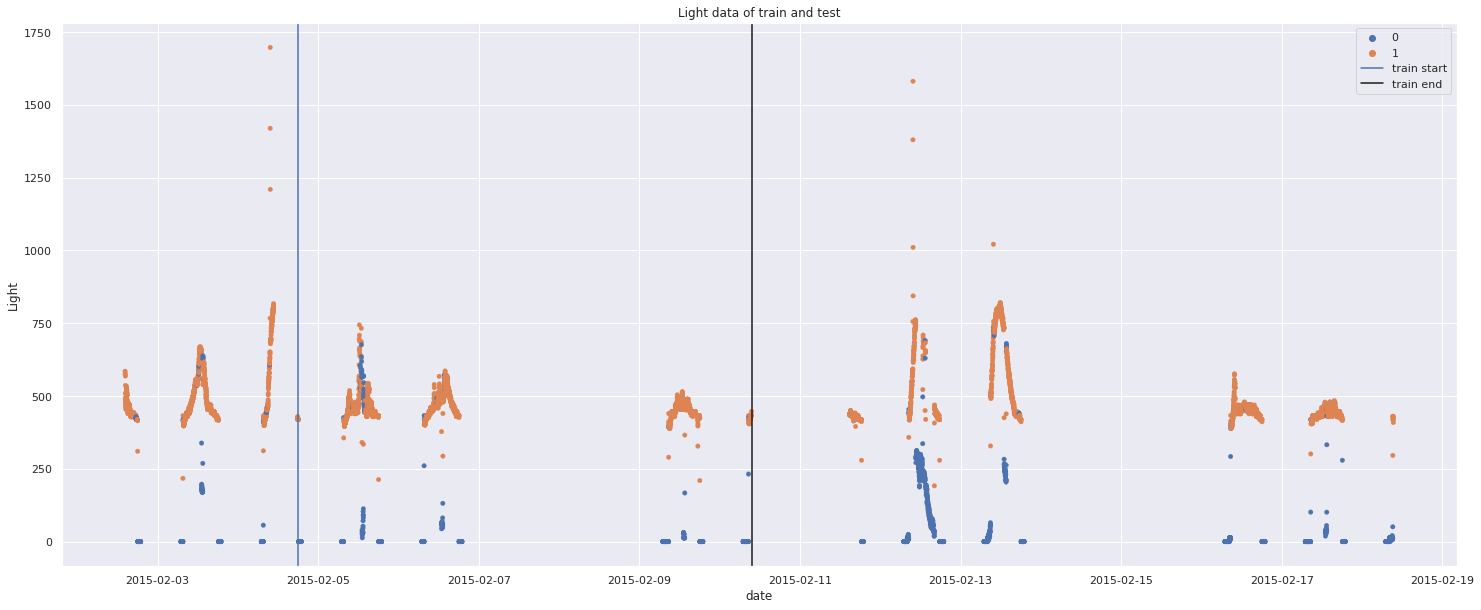

In [54]:
wh_mask = np.logical_and(weekday_data['date'].dt.hour <= 18, weekday_data['date'].dt.hour >= 7)
working_hours_data = weekday_data[wh_mask]

plt.figure(figsize=(25,10))
sns.scatterplot(working_hours_data.date,working_hours_data.Light, hue = working_hours_data.Occupancy, s= 20,edgecolor=None)
plt.title('Light data of train and test')
plt.axvline(x = train_start, color = 'b', label = 'train start')
plt.axvline(x = train_end, color = 'k', label = 'train end')
plt.legend()
plt.show()

## Adding a boolean variable for workday start

Adding additional features to help the model learn is quite often a good thing.  Especially if you can break down specific features for the model

In [44]:
occupied = train[train.Occupancy == 1]
occupied['date'].dt.hour.value_counts().sort_index()

7      33
8     149
9     214
10    179
11    173
12    159
13     83
14    166
15    180
16    183
17    186
18     24
Name: date, dtype: int64

Here we can see in all of the training data that people are only in office from 7 to 18.

In [30]:
start_h = 7
end_h = 18
wd_mask          = train['date'].dt.weekday < 5
wh_mask_tmp      = np.logical_and(train['date'].dt.hour <= end_h, train['date'].dt.hour >= start_h)
wh_mask      = np.logical_and(wh_mask_tmp , wd_mask)

train['Work-hour'] = wh_mask.astype(int) # only int now for correlation
train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Work-hour
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,1


## Variable correlation of only working hours with new feature

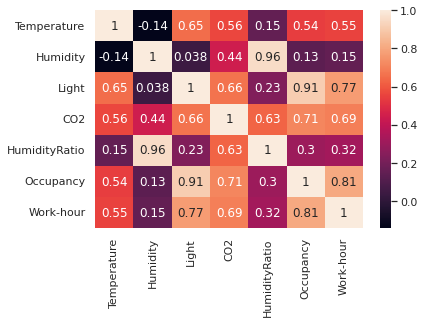

In [31]:
sns.heatmap(train.corr(), annot=True)
plt.show()

Above we can see that humidity has the least correlation with the prediction, but every feature seems to be significantly correclated during working hours.